In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
import numpy as np


# Q1. Cubic Least Square

In [3]:
#Using pandas to read the data
data = pd.read_csv("assign2fit.txt", sep='\t')
data

,# x,y
0,0.00,0.486
1,0.05,0.866
2,0.10,0.944
3,0.15,1.144
4,0.20,1.103
5,0.25,1.202
6,0.30,1.166
7,0.35,1.191
8,0.40,1.124
9,0.45,1.095


In [4]:
xvals = np.array(data.iloc[:,0])
yvals = np.array(data.iloc[:,1])
xvals, yvals

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 array([0.486, 0.866, 0.944, 1.144, 1.103, 1.202, 1.166, 1.191, 1.124,
        1.095, 1.122, 1.102, 1.099, 1.017, 1.111, 1.117, 1.152, 1.265,
        1.38 , 1.575, 1.857]))

Define LU_decomposition

In [5]:
def forward_backward(U, L, b):
    y = [0 for i in range(len(b))]

    for i in range(len(b)):
        total = 0
        for j in range(i):
            total += L[i][j] * y[j]
        y[i] = b[i] - total

    x = [0 for i in range(len(b))]

    for i in reversed(range(len(b))):
        total = 0
        for j in range(i + 1, len(b)):
            total += U[i][j] * x[j]
        x[i] = (y[i] - total) / U[i][i]

    return x

def partial_pivot(A, b):
    count = 0  
    n = len(A)
    for i in range(n - 1):
        if abs(A[i][i]) < 1e-10:
            for j in range(i + 1, n):
                if abs(A[j][i]) > abs(A[i][i]):
                    A[j], A[i] = (A[i],A[j],)  
                    count += 1
                    b[j], b[i] = (b[i],b[j],)  

    return A, b, count
    
def crout(A):
    U = [[0 for i in range(len(A))] for j in range(len(A))]
    L = [[0 for i in range(len(A))] for j in range(len(A))]

    for i in range(len(A)):
        L[i][i] = 1

    for j in range(len(A)):
        for i in range(len(A)):
            total = 0
            for k in range(i):
                total += L[i][k] * U[k][j]

            if i == j:
                U[i][j] = A[i][j] - total

            elif i > j:
                L[i][j] = (A[i][j] - total) / U[j][j]

            else:
                U[i][j] = A[i][j] - total

    return U, L

def lu_decomposition(A, b):
    partial_pivot(A, b)
    U, L = crout(A)
    x = forward_backward(U, L, b)
    return x

In [6]:
def mlcg(seed: float, a: float, m: float, num: int) -> list:
    x = seed
    rands = []
    for i in range(num):
        x = (a * x) % m
        rands.append(x)

    return rands

Defining polynomial least square fitting function

In [8]:
def leastSquare(xvals, yvals, degree = 1):
    n = len(xvals)
    params = degree + 1  # no. of parameters
    A = np.zeros((params, params))  # Matrix
    b = np.zeros(params)  # Vector

    for i in range(params):
        for j in range(params):
            total = 0
            for k in range(n):
                total += xvals[k] ** (i + j)

            A[i, j] = total

    for i in range(params):
        total = 0
        for k in range(n):
            total += xvals[k] ** i * yvals[k]

        b[i] = total
        
#     print(A,b)

    paramsVec = lu_decomposition(A, b)
    
#     print(paramsVec)
    return paramsVec, A

Chebyshev fitting

In [9]:
def chebyshev(x, order):
    if order == 0:
        return 1
    elif order == 1:
        return 2 * x - 1
    elif order == 2:
        return 8 * x**2 - 8 * x + 1
    elif order == 3:
        return 32 * x**3 - 48 * x**2 + 18 * x - 1


def chebyshevfit(xvals, yvals, degree):
    n = len(xvals)
    params = degree + 1
    A = np.zeros((params, params))
    b = np.zeros(params)

    for i in range(params):
        for j in range(params):
            total = 0
            for k in range(n):
                total += chebyshev(xvals[k], j) * chebyshev(xvals[k], i)

            A[i, j] = total

    for i in range(params):
        total = 0
        for k in range(n):
            total += chebyshev(xvals[k], i) * yvals[k]

        b[i] = total

    paramsVec = lu_decomposition(A, b)
    return paramsVec, A

In [10]:
# Condition number of matrix = 21980.9
degree = 3

params, mat1 = leastSquare(xvals, yvals, degree)
chebyshevparams, mat2 = chebyshevfit(xvals, yvals, degree)

In [11]:
params_df = pd.DataFrame({
    'original basis': params,
    'chebysev basis': chebyshevparams
})
params_df

,original basis,chebysev basis
0,0.574659,1.160969
1,4.725861,0.393514
2,-11.128218,0.046850
3,7.668678,0.239646


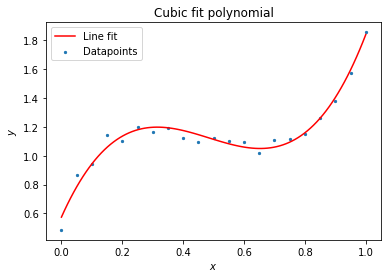

In [12]:
a0, a1, a2, a3 = params[0], params[1], params[2], params[3]

x = np.linspace(0, 1, 100)
y = a0 + a1 * x + a2 * x**2 + a3 * x**3
plt.scatter(xvals, yvals, s=5, label="Datapoints")
plt.plot(x, y, "r", label="Line fit")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Cubic fit polynomial")
plt.legend()
plt.show()

# Q2. Value of $\pi$ 

In [13]:
def mlcg_rand(seed, a, m, num):
    x = seed
    rands = []
    for i in range(num):
        x = (a * x) % m
        rands.append(x)

    return rands

#1/4 of a circle of unit radius
def integral(x):
    return sqrt(1 - x**2)

def integratedPi(func, seed, a, m, N):
    xrand = mlcg_rand(seed, a, m, N)
    xrand = np.array(xrand)/m

    summ = 0
    for i in range(N):
        summ += func(xrand[i])

    total = 1 / float(N) * summ

    return total


def throwPi(seed1, seed2, a, m, N):
    xrand = mlcg(seed1, a, m, N)
    yrand = mlcg(seed2, a, m, N)
    xrand = np.array(xrand)/m
    yrand = np.array(yrand)/m

    hits = 0
    for i in range(N):
        if xrand[i]**2 + yrand[i]**2 <= 1:
            hits += 1

    estim = hits / N
    return estim

In [14]:
a = 65
m = 1021
seed = 100
integrate_pi = integratedPi(integral, seed, a, m, 100000)
throw_pi = throwPi(75.345, 36.232, 65, 1021, 100000)
integrate_pi*4, throw_pi*4

(3.142720688383342, 3.14048)

In [15]:
a = 572
m = 16381
seed_1 = 100
seed_2 = 10
integrated_pi = integratedPi(integral, 234.34, a, m, 100000)
throw_pi = throwPi(seed_1, seed_2, 572, 16381, 100000)
integrated_pi*4, throw_pi*4

(3.1411842545237674, 3.11996)

# Q3. Volume of Steinmetz Solid

In [16]:
def random_MLCG(L_limit, U_limit, a = 1103515245, m = 2**32, x0 = 572):
    m1 = 0

    if 'MLCG' not in globals():
        global MLCG
        MLCG = x0
        
    MLCG = (a * MLCG)%m
    random = MLCG/m
    random = L_limit + (U_limit - L_limit) * random

    return random

def circle(x, y):
    return sqrt((x**2 + y**2))

def steinmetzVolMC(lims, circle, N):

    x1, x2, y1, y2, z1, z2 = lims
    vol_box = (x2 - x1) * (y2 - y1) * (z2 - z1)
    ans = 0
    count = 0

    for i in range(N):
        x = random_MLCG(x1, x2)
        y = random_MLCG(y1, y2)
        z = random_MLCG(z1, z2)

        if (circle(x,y) <= 1) and (circle(y,z) <= 1):
            count += 1
    return (vol_box/float(N)) * count


In [17]:
lims = [-1,1]*3

N = 90000

volume = steinmetzVolMC(lims, circle ,N)
volume

5.340533333333334